In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import math

In [245]:
train = pd.read_csv('train_final_best.csv')
test = pd.read_csv('test_final_best.csv')
train.columns

Index(['Unnamed: 0', 'distance', 'price', 'surge_multiplier', 'temp', 'clouds',
       'pressure', 'rain', 'humidity', 'wind', 'uber', 'product_accessible',
       'product_luxury', 'product_shared', 'product_standard', 'product_suv',
       'product_town_car', 'product_xl', 'distance_x_multiplier',
       'log_distance_x_multiplier', 'log_distance'],
      dtype='object')

### change cab_type to binary value 

## WEATHER EDA
#### create indicator value for strength of wind/rain/humidity

## WIND

In [246]:
wd25, wd50, wd75 = train['wind'].quantile([0.25, 0.5, 0.75])
ws25, ws50, ws75 = train['wind'].quantile([0.25, 0.5, 0.75])

In [247]:
# wind destination 
train.loc[train['wind'] < wd25, 'wind_d_strength'] = 1
train.loc[((train['wind'] < wd50) & (train['wind'] >= wd25)), 'wind_d_strength'] = 2
train.loc[((train['wind'] < wd75) & (train['wind'] >= wd50)), 'wind_d_strength'] = 3
train.loc[train['wind'] >= wd75, 'wind_d_strength'] = 4

<AxesSubplot:xlabel='wind_d_strength', ylabel='price'>

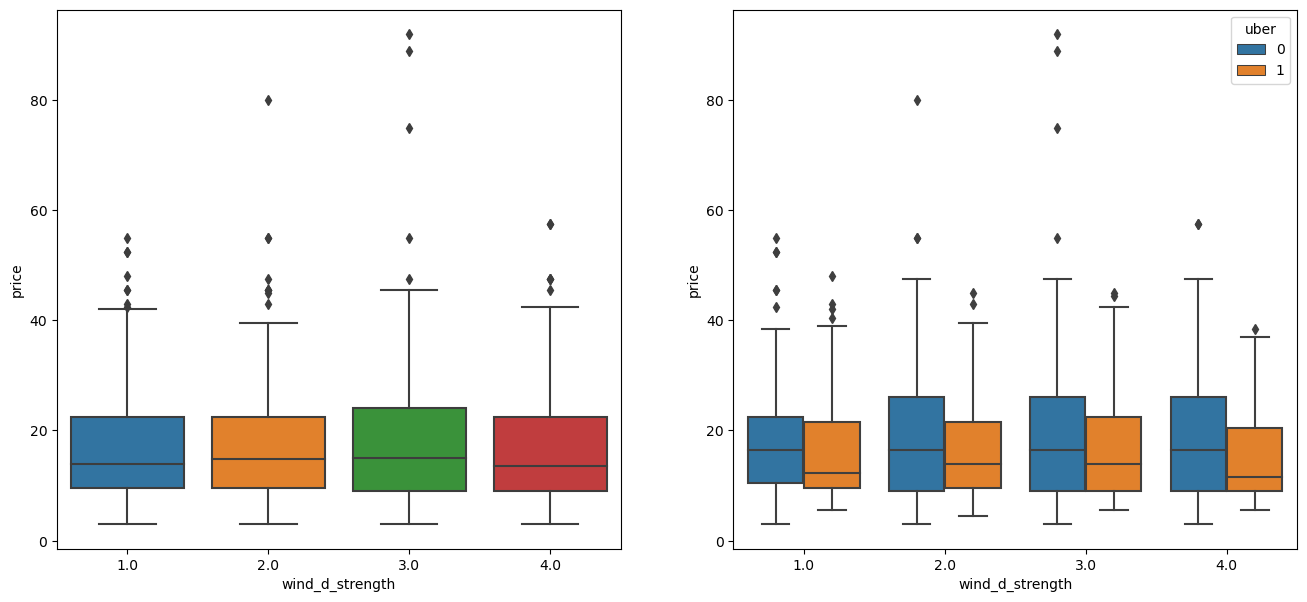

In [250]:
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax=ax[0], data = train, x = 'wind_d_strength', y = 'price')
sns.boxplot(ax=ax[1], data = train, x = 'wind_d_strength', y = 'price', hue = 'uber')


#### conclusion: prices of ubers were marginally higher for when wind_strength was 1 (its lowest), however, it does appear that in general at every rain strength, cab_type 1 (Uber) offers a lower price

## RAIN

In [30]:
rd25, rd50, rd75 = train['rain'].quantile([0.25, 0.5, 0.75])
rs25, rs50, rs75 = train['rain'].quantile([0.25, 0.5, 0.75])

In [251]:
# rain destination 
train.loc[train['rain'] < rd25, 'rain_d_strength'] = 1
train.loc[((train['rain'] < rd50) & (train['rain'] >= rd25)), 'rain_d_strength'] = 2
train.loc[((train['rain'] < rd75) & (train['rain'] >= rd50)), 'rain_d_strength'] = 3
train.loc[train['rain'] >= rd75, 'rain_d_strength'] = 4

<AxesSubplot:xlabel='rain_d_strength', ylabel='price'>

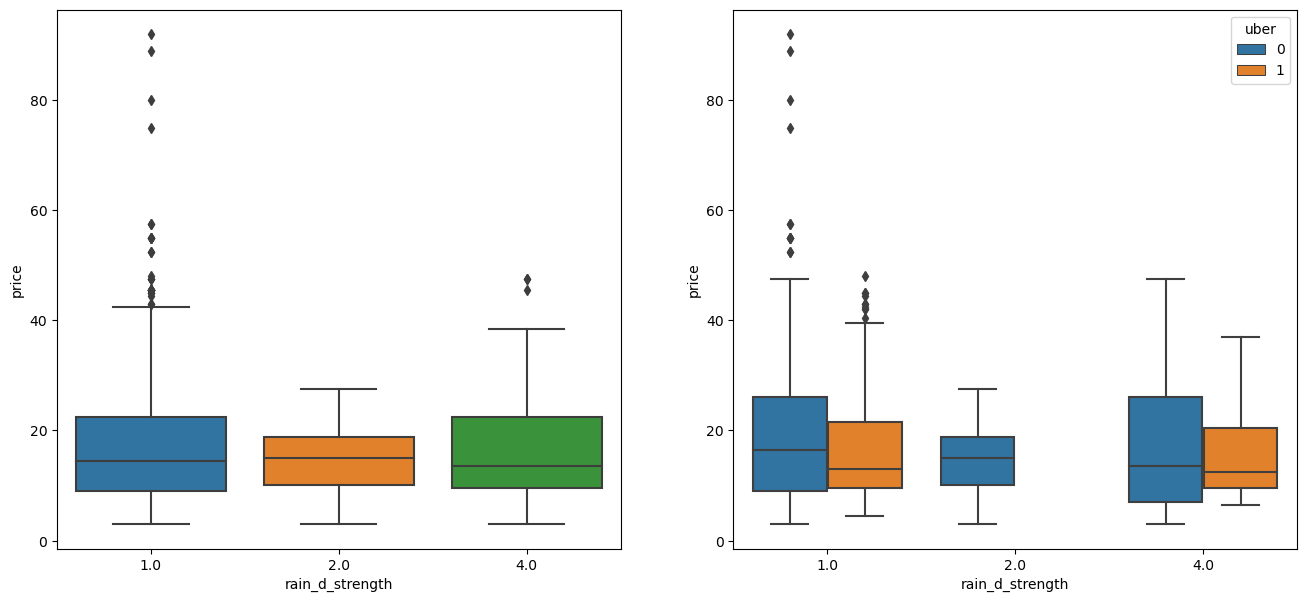

In [252]:
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'rain_d_strength', y = 'price')
sns.boxplot(ax = ax[1], data = train, x = 'rain_d_strength', y = 'price', hue = 'uber')

#### remove outliers

In [47]:
rainnooutliers = train[train['price'] <45] # super approximate removal of outliers

rd25, rd50, rd75 = rainnooutliers['rain_destination'].quantile([0.25, 0.5, 0.75])
rs25, rs50, rs75 = rainnooutliers['rain_source'].quantile([0.25, 0.5, 0.75])

# rain destination 
rainnooutliers.loc[rainnooutliers['rain_destination'] < rd25, 'rain_d_strength'] = 1
rainnooutliers.loc[((rainnooutliers['rain_destination'] < rd50) & (rainnooutliers['rain_destination'] >= rd25)), 'rain_d_strength'] = 2
rainnooutliers.loc[((rainnooutliers['rain_destination'] < rd75) & (rainnooutliers['rain_destination'] >= rd50)), 'rain_d_strength'] = 3
rainnooutliers.loc[rainnooutliers['rain_destination'] >= rd75, 'rain_d_strength'] = 4


<AxesSubplot:xlabel='rain_s_strength', ylabel='price'>

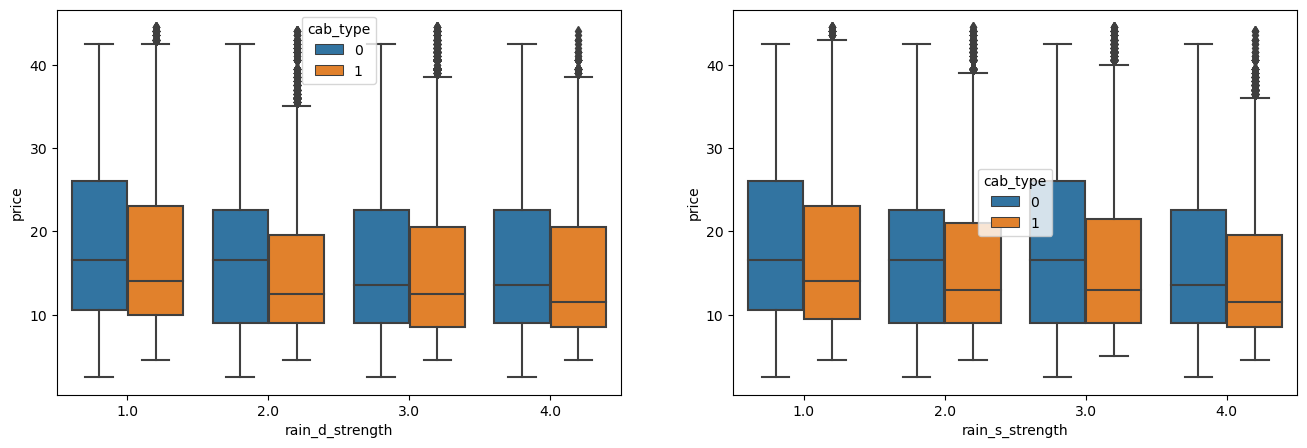

In [75]:
fig, ax =plt.subplots(1,2, figsize=(16, 5))
sns.boxplot(ax=ax[0],data = rainnooutliers, x = 'rain_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax=ax[1],data = rainnooutliers, x = 'rain_s_strength', y = 'price', hue = 'cab_type')


#### conclusion: doesn't seem to be a huge correlation between rain strength and price of ride. however, it does appear that in general at every rain strength, cab_type 1 (Uber) offers a lower price

## HUMIDITY

In [55]:
hd25, hd50, hd75 = train['humidity_destination'].quantile([0.25, 0.5, 0.75])
hs25, hs50, hs75 = train['humidity_source'].quantile([0.25, 0.5, 0.75])

In [77]:
# humidity destination 
train.loc[train['humidity_destination'] < hd25, 'humidity_d_strength'] = 1
train.loc[((train['humidity_destination'] < hd50) & (train['humidity_destination'] >= hd25)), 'humidity_d_strength'] = 2
train.loc[((train['humidity_destination'] < hd75) & (train['humidity_destination'] >= hd50)), 'humidity_d_strength'] = 3
train.loc[train['humidity_destination'] >= hd75, 'humidity_d_strength'] = 4

In [78]:
# humidity source 
train.loc[train['humidity_source'] < hd25, 'humidity_s_strength'] = 1
train.loc[((train['humidity_source'] < hd50) & (train['humidity_source'] >= hd25)), 'humidity_s_strength'] = 2
train.loc[((train['humidity_source'] < hd75) & (train['humidity_source'] >= hd50)), 'humidity_s_strength'] = 3
train.loc[train['humidity_source'] >= hd75, 'humidity_s_strength'] = 4

<AxesSubplot:xlabel='humidity_s_strength', ylabel='price'>

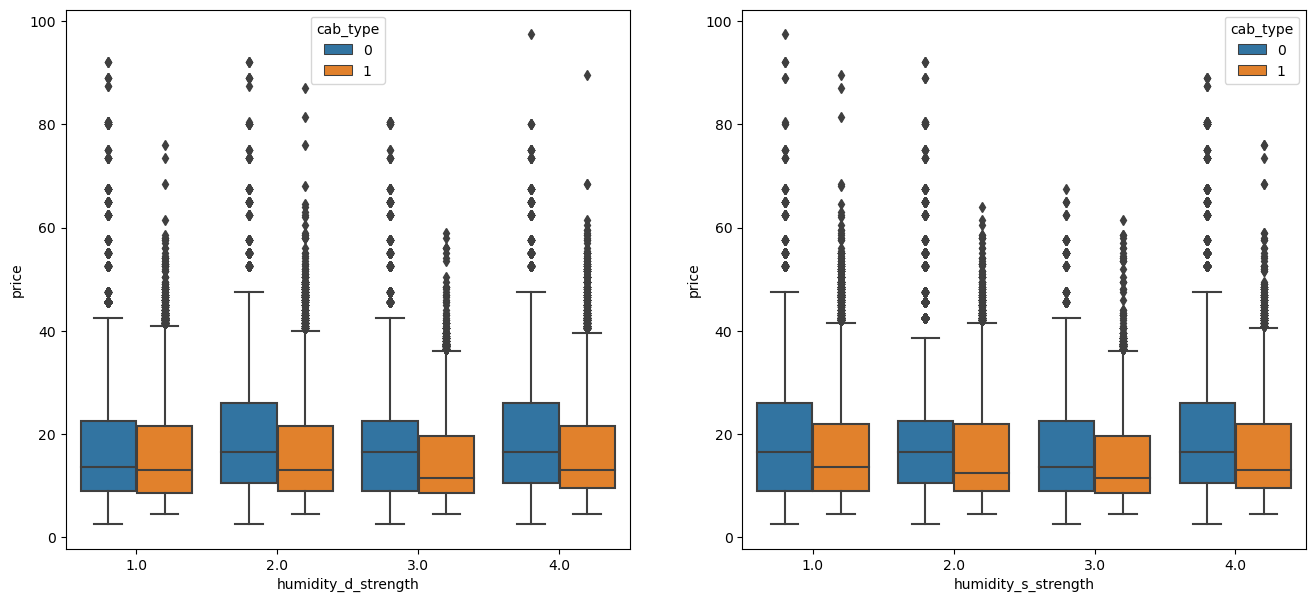

In [79]:
fig, ax =plt.subplots(1,2, figsize=(16, 7))
sns.boxplot(ax = ax[0], data = train, x = 'humidity_d_strength', y = 'price', hue = 'cab_type')
sns.boxplot(ax = ax[1], data = train, x = 'humidity_s_strength', y = 'price', hue = 'cab_type')

#### 3 levels of strength...

In [116]:
# humidity source 
train.loc[train['humidity_source'] < hs25, 'humidity_s_strength_3'] = 1
train.loc[((train['humidity_source'] < hs75) & (train['humidity_source'] >= hs25)), 'humidity_s_strength_3'] = 2
train.loc[train['humidity_source'] >= hs75, 'humidity_s_strength_3'] = 3

<AxesSubplot:xlabel='humidity_s_strength_3', ylabel='price'>

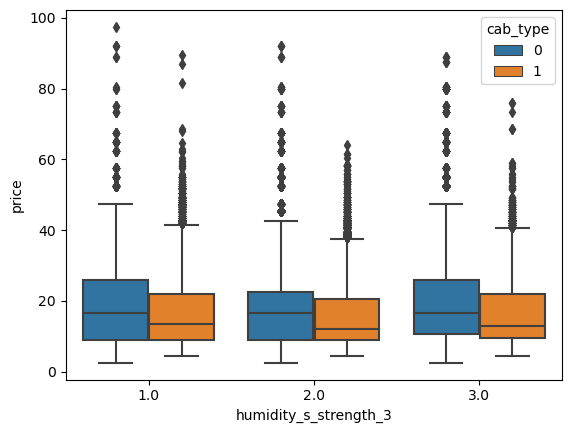

In [117]:
sns.boxplot(data = train, x = 'humidity_s_strength_3', y = 'price', hue = 'cab_type')

#### conclusion: no strong correlation, could keep trying dif strength categories (not just sticking to 25, 50, 75 percentile. but doesn't seem like strong relationship. but again, uber is in general priced lower

## note: humidity and rain are probably closely related, look into when building model

## LOCATION EDA

In [253]:
locationdf = pd.DataFrame(train.iloc[:,17:41].sum()).reset_index()
locationdf.columns = ['location', 'count']
locationdf.sort_values(by = 'count', ascending = False)

,location,count
4,wind_d_strength,6228.000000
1,distance_x_multiplier,5559.812500
5,rain_d_strength,2999.000000
2,log_distance_x_multiplier,1589.280605
3,log_distance,1549.115297
0,product_xl,418.000000


[Text(0.5, 0, 'Location')]

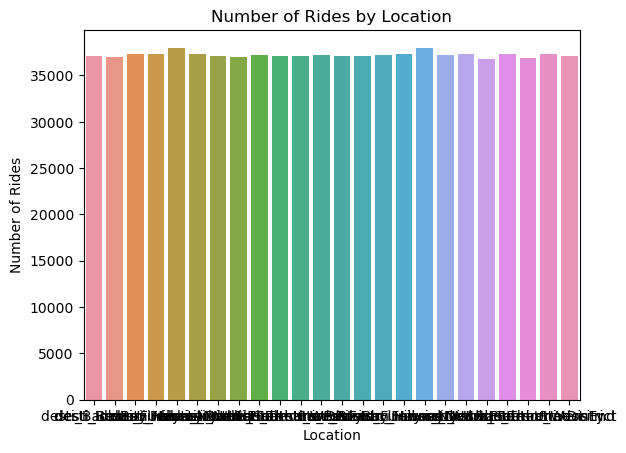

In [202]:
a = sns.barplot(data = locationdf, x = 'location', y = 'count')
a.set(title='Number of Rides by Location')
a.set(ylabel='Number of Rides')
a.set(xlabel='Location')

#### conclusion/thoughts: there aren't super big fluctuations between number of rides to/from each of these places. The financial district has the highest amount of rides BOTH to and from, followed closely by src_Northeastern University (which makes sense since it's a school). I'd imagine that these peaks would be a lot more pronounced if we had data that had been collected over a larger amount of time

#### could make indicator column -- 1 for popular location (financial district, schools), 0 otherwise. but again, the differences aren't super pronounced so i don't think it would help the model that much

## creating indicator column for "bad weather" 
#### combines wind, rain, humidity

In [256]:
train.loc[(train['wind_d_strength'] == 4) & (train['rain_d_strength'] == 4), 'bad_weather'] = 1


In [257]:
train.fillna(0, inplace = True)
train

,Unnamed: 0,distance,price,surge_multiplier,temp,clouds,pressure,rain,humidity,wind,...,product_standard,product_suv,product_town_car,product_xl,distance_x_multiplier,log_distance_x_multiplier,log_distance,wind_d_strength,rain_d_strength,bad_weather
0,3545,2.82,9.5,1.0,34.94,0.82,991.21,0.000,0.75,6.41,...,1,0,0,0,2.82,1.036737,1.036737,2.0,1.0,0.0
1,1576,2.05,7.0,1.0,41.52,0.85,991.69,0.000,0.63,9.90,...,0,0,0,0,2.05,0.717840,0.717840,3.0,1.0,0.0
2,3045,3.28,27.5,1.0,40.83,1.00,1014.75,0.000,0.93,1.24,...,0,0,1,0,3.28,1.187843,1.187843,1.0,1.0,0.0
3,2956,0.99,27.5,1.0,41.38,0.91,991.51,0.002,0.63,9.34,...,0,1,0,0,0.99,-0.010050,-0.010050,2.0,1.0,0.0
4,358,1.61,8.5,1.0,39.97,0.12,1022.78,0.000,0.61,3.34,...,1,0,0,0,1.61,0.476234,0.476234,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478,1731,1.61,33.0,1.0,40.11,0.95,1015.20,0.000,0.93,2.60,...,0,1,0,0,1.61,0.476234,0.476234,1.0,1.0,0.0
2479,1162,1.21,5.0,1.0,41.14,0.93,993.44,0.000,0.63,8.49,...,0,0,0,0,1.21,0.190620,0.190620,2.0,1.0,0.0
2480,1867,2.49,22.5,1.0,38.92,0.04,992.10,0.000,0.72,7.50,...,0,0,1,0,2.49,0.912283,0.912283,2.0,1.0,0.0
2481,2301,1.79,26.0,1.0,33.23,0.37,990.64,0.000,0.82,6.52,...,0,1,0,0,1.79,0.582216,0.582216,2.0,1.0,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[Text(0, 0.5, 'Price')]

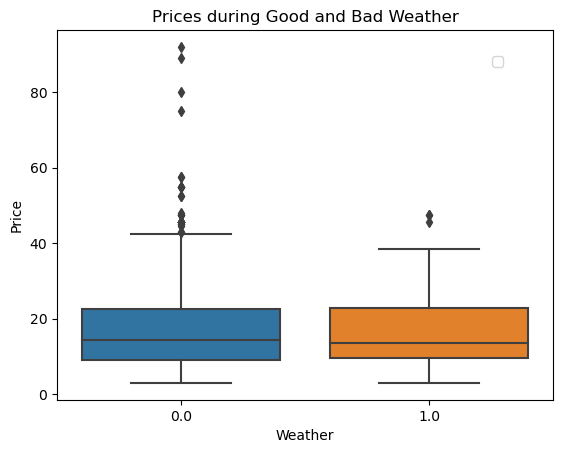

In [258]:
a = sns.boxplot(data = train, x = 'bad_weather', y = 'price')
plt.legend(bbox_to_anchor=(0.9, 0.93), borderaxespad=0)
a.set(title = 'Prices during Good and Bad Weather')
a.set(xlabel = 'Weather')
a.set(ylabel = 'Price')

Text(0, 0.5, 'Price')

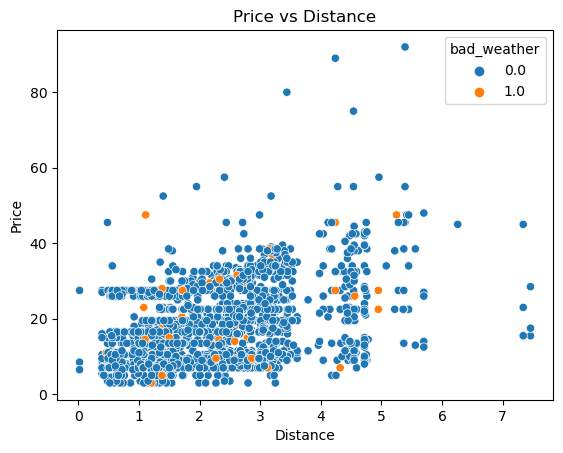

In [259]:
sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'bad_weather')
plt.title('Price vs Distance')
plt.xlabel('Distance')
plt.ylabel('Price')


#### bad weather genuinely doesn't seem to affect price...... BUT it appears that most of the rides taken during bad weather happen for shorter distances --- might just be a convenience thing. and could explain why it doens't corerspond with higher prices bc distance is the largest determiner of price and most rides called during bad weather are shorter rides

#### !!!!!!

### only looking at shorter rides - still no takeaway. 

In [160]:
shorterrides = train[train['distance'] < 4]

<AxesSubplot:xlabel='bad_weather', ylabel='price'>

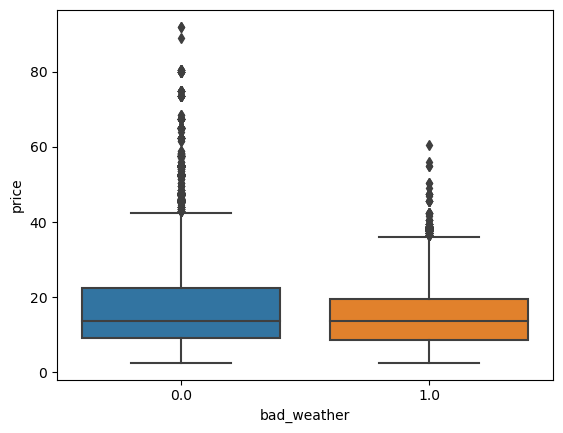

In [158]:
sns.boxplot(data = shorterrides, x = 'bad_weather', y = 'price')

In [177]:
badweather = train[train['bad_weather'] == 1]
uber = train[train['cab_type']==1]

Text(36.30377083333334, 0.5, 'Price')

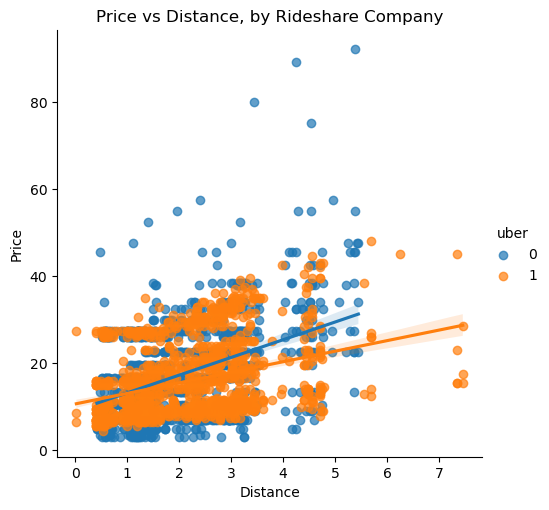

In [265]:
sns.lmplot(data = train, x = 'distance', y = 'price', hue = 'uber', scatter_kws={'alpha':0.7})
plt.title('Price vs Distance, by Rideshare Company')
plt.xlabel('Distance')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

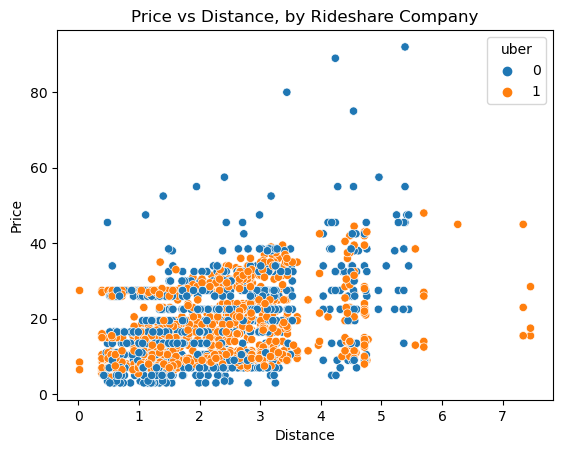

In [260]:
sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'uber')
plt.title('Price vs Distance, by Rideshare Company')
plt.xlabel('Distance')
plt.ylabel('Price')

Text(0, 0.5, 'Price')

/Users/cindywu/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


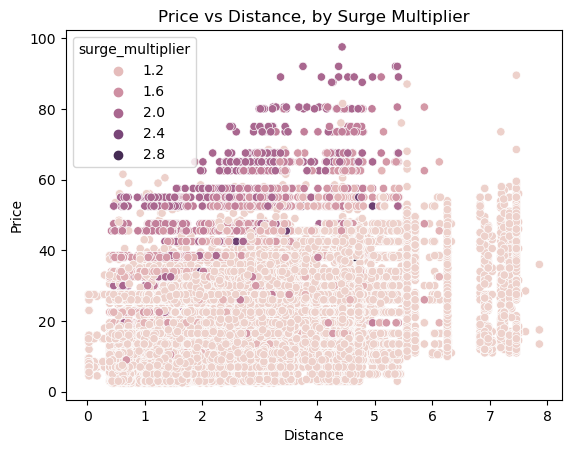

In [237]:
a = sns.scatterplot(data = train, x = 'distance', y = 'price', hue = 'surge_multiplier')
plt.title('Price vs Distance, by Surge Multiplier')
plt.xlabel('Distance')
plt.ylabel('Price')


#### weather doesn't play super big role in determining price but probably just bc surge multiplier covers it -- demand goes up when weather is bad and that's reflected in the surge multiplier